In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.layers import Embedding, Flatten, StringLookup
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

In [2]:
df_train = pd.read_csv("subtaskA_train.csv", index_col='Id')
df_train.head()

,comment_text,conspiratorial
Id,,
0,⚡Se non ci fossero soldati non ci sarebbero gu...,0
1,"21/08/21]( [PRE-PRINT]\r\n\r\n📄__ ""Shedding of...",1
2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [3]:
df_train.shape

(1842, 2)

In [4]:
X_train = np.array(df_train.comment_text) # np.array di stringhe

# Data Preprocessing

In [5]:
import nltk.data

## Sentence Splitting

In [6]:
splitter = nltk.data.load('tokenizers/punkt/italian.pickle')

In [7]:
X_train_splitted = []
for post in X_train:
    X_train_splitted.append(splitter.tokenize(post))

In [8]:
len(X_train_splitted)

1842

In [9]:
X_train_splitted[:2]

[['⚡Se non ci fossero soldati non ci sarebbero guerre.'],
 ['21/08/21]( [PRE-PRINT]\r\n\r\n📄__ "Shedding of Infectious SARS-CoV-2 Despite Vaccination"\r\n🇮🇹 "Diffusione del SARS-CoV-2 nonostante la vaccinazione"__\r\n\r\n📊 "La variante Delta del SARS-CoV-2 può causare elevate cariche virali, è al trasmissibile e contiene mutazioni che conferiscono una fuga immunitaria parziale.',
  '[...] le indagini sull\'epidemia suggeriscono che le persone vaccinate possono diffondere [la variante] Delta"\r\n\r\n⚠️ "[...] questi risultati indicano che anche le **persone asintomatiche e comple vaccinate possono diffondere il virus infettivo**."',
  '⚠️ "[...] questi dati indicano che gli individui **vaccinati e non vaccinati** infettati dalla variante Delta **possono trasmettere l\'infezione**."',
  '📚 **']]

## Tokenization and Word Normalization

In [62]:
from nltk.tokenize import TweetTokenizer # Twitter-specific tokenizer
tokenizer = TweetTokenizer()

In [11]:
import re

def get_digits(text):
    try:
      val = int(text) # converte la stringa in intero
    except:
      text = re.sub('\d', '@Dg', text) # sostituisce a ogni cifra in text la stringa '@Dd'
      return text
    if val >= 0 and val < 2100: # se è un numero tra 0 e 2100
      return str(val) # viene lasciato uguale
    else:
      return "DIGLEN_" + str(len(str(val))) # viene indicato il numero di cifre che compongono quel numero

def normalize_text(word):
    if "http" in word or ("." in word and "/" in word):
      word = str("___URL___")
      return word
    if len(word) > 26:
      return "__LONG-LONG__"
    new_word = get_digits(word)
    if new_word != word:
      word = new_word
    if word[0].isupper(): # se la parola inizia con la lettera maiuscola
      word = word.capitalize() # solo la prima viene lasciata maiuscola
    else:
      word = word.lower() # tutta in minuscolo
    return word

In [12]:
X_train_tokenized = []
for post in X_train_splitted:
    post_tokens = []
    for sentence in post:
        sentence_tokens = [normalize_text(word) for word in tokenizer.tokenize(sentence)]
        post_tokens.append(sentence_tokens)
    X_train_tokenized.append(post_tokens)

In [13]:
len(X_train_tokenized)

1842

In [14]:
X_train_tokenized[0]

[['⚡',
  'Se',
  'non',
  'ci',
  'fossero',
  'soldati',
  'non',
  'ci',
  'sarebbero',
  'guerre',
  '.']]

In [109]:
X_train_tokenized_flatten = []
for post in X_train_splitted:
    post_tokens = []
    for sentence in post:
        sentence_tokens = [normalize_text(word) for word in tokenizer.tokenize(sentence)]
        for word in sentence_tokens:
            post_tokens.append(word)
    X_train_tokenized_flatten.append(post_tokens)

## Manual Padding

In [15]:
max_length = float('-inf')
for post in X_train_tokenized:
    post_words = 0
    for sentence in post:
        post_words += len(sentence)
    if post_words > max_length:
        max_length = post_words

max_length

In [110]:
for post in X_train_tokenized_flatten:
    if len(post) < max_length:
        for i in range(max_length-len(post)):
            post.append('[UNK]')

In [111]:
X_train_tokenized_flatten = np.array(X_train_tokenized_flatten)

In [113]:
X_train_tokenized_flatten.shape

(1842, 708)

## String-to-Integer mapping

In [114]:
string_lookup_layer = StringLookup()
# This layer translates a set of strings into integer via a table-based vocabulary lookup. This layer will perform no
# splitting or transformation of input strings.

In [115]:
string_lookup_layer.adapt(X_train_tokenized_flatten)
# the data to train on can be passed either as a`tf.data.Dataset`, or as a numpy array.

In [116]:
len(string_lookup_layer.get_vocabulary())

16894

## Word Embeddings

### Glove

In [7]:
import gensim.downloader as dl
glove_embeddings = dl.load('glove-wiki-gigaword-50') # glove-twitter-25

c:\Users\irene\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [102]:
X_train_embeddings = []
not_found = []
for post in X_train_tokenized:
    post_embeddings = []
    for sentence in post:
        sentence_embeddings = []
        for word in sentence:
            if word in glove_embeddings:
                sentence_embeddings.append(glove_embeddings[word])
            else:
                not_found.append(word)
        post_embeddings.append(sentence_embeddings)
    X_train_embeddings.append(post_embeddings)

In [103]:
len(not_found)

40956

Una merda, proviamo con gli embedding specifici per l'italiano

### Itwac

In [26]:
embeddings_path = 'itwac128.txt.gitignore'

In [27]:
def load_word_embeddings(emb_path):
    '''crea un dizionario contenente gli embedding di parole presente nel file src_path'''
    embeddings = dict() # dizionario che conterrà gli embedding
    for line in open(emb_path, 'r'):
        line = line.strip().split('\t')
        word = line[0]
        embedding = line[1:]
        embedding = [float(comp) for comp in embedding] # convertiamo le componenti dell'embedding in float
        embeddings[word] = np.asarray(embedding) # trasformiamo la lista delle componenti in un vettore di numpy
    return embeddings

In [29]:
embeddings = load_word_embeddings(embeddings_path)

In [66]:
len(embeddings)

1247492

In [128]:
r = np.random.RandomState(42)
X_train_embeddings = []
not_found = []
for post in X_train_tokenized_flatten:
    post_embeddings = []
    for word in post:
        if word == '[UNK]':
            post_embeddings.append(r.uniform(-0.2, 0.2, 128)) # initialize always with the same random weights
        elif word in embeddings:
            post_embeddings.append(embeddings[word])
        else:
            not_found.append(word)
            post_embeddings.append(np.random.uniform(-0.2, 0.2, 128)) # initialize with random weights
    X_train_embeddings.append(post_embeddings)

In [129]:
len(not_found)

5761

In [130]:
len(X_train_embeddings)

1842

In [132]:
X_train_embeddings = np.array(X_train_embeddings)

In [133]:
X_train_embeddings.shape

(1842, 708, 128)

# Model Building

In [134]:
model = Sequential()

In [137]:
model.add(Embedding(708,
                    128, 
                    weights=[X_train_embeddings], 
                    #input_length=maxlen, 
                    trainable=True))
model.add(Flatten())

ValueError: Layer embedding_1 weight shape (708, 128) is not compatible with provided weight shape (1842, 708, 128).

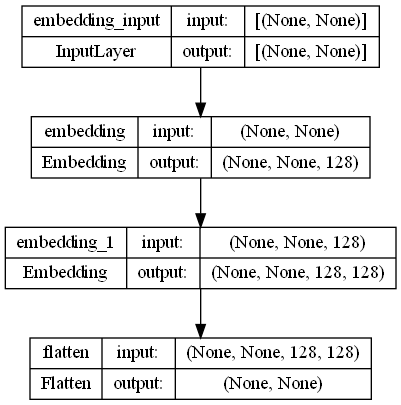

In [83]:
plot_model(model, show_shapes=True)